<a href="https://colab.research.google.com/github/jetsonai/Working-R-Ssaem/blob/main/CNN/%5B2%5D_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **데이터 증강 (Data Augmentation)을 활용한 이미지 분류 모델 성능 향상**

## 1. 라이브러리 불러오기

In [ ]:
!pip3 install torchmetrics

In [ ]:
from os import makedirs

import random

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from torchmetrics import Accuracy
from torchsummary import summary
from tqdm import tqdm

## 2. 시드 고정

In [ ]:
def fix_seed(seed) :
  # Fix Seed
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

## 3. 손실 함수 및 평가 지표 평균화

In [ ]:
class AverageMeter(object) :
  def __init__(self) :
    self.reset()

  def reset(self) :
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1) :
    self.val = val
    self.sum += val*n
    self.count += n
    self.avg = self.sum/self.count

## 4. 데이터 증강 기법 시각화

### CIFAR10 데이터셋

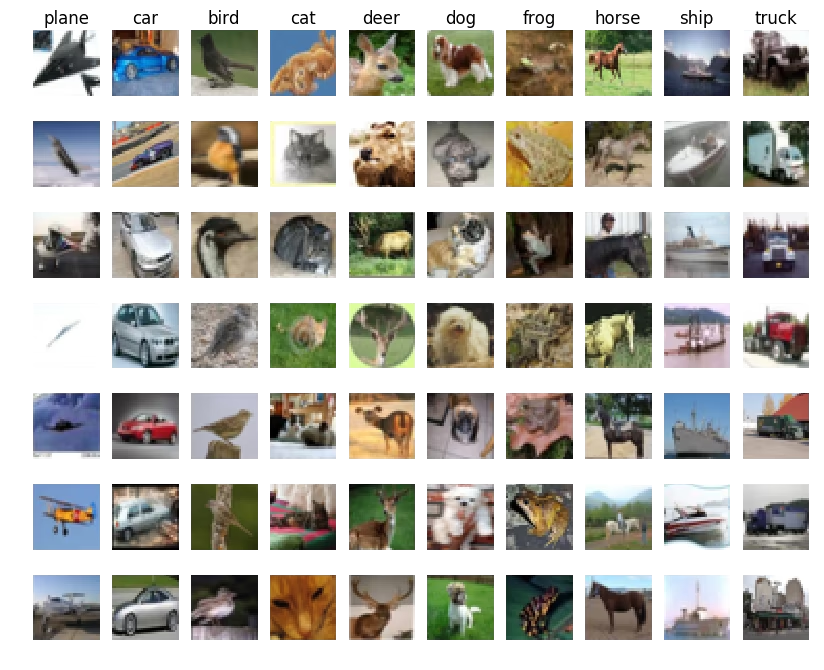

In [ ]:
########## Data Augmentation Visualization Code ##########
def visualize_data_aug() :
  # Load Dataset
  transform_original = transforms.Compose([transforms.Resize(256),
                                           transforms.ToTensor()])
  transform_data_aug = transforms.Compose([transforms.Resize(256),
                                           transforms.RandomHorizontalFlip(0.5),
                                           transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                                                                          saturation=0.2, hue=0.1)], p=0.8),
                                           transforms.ToTensor()])

  # Download Fashion MNIST Dataset
  dataset_original = datasets.CIFAR10("data/", train=True, transform=transform_original, download=True)
  dataset_data_aug = datasets.CIFAR10("data/", train=True, transform=transform_data_aug, download=True)

  # Create DataLoader
  loader_original = DataLoader(dataset_original, batch_size=10, shuffle=False)
  loader_data_aug = DataLoader(dataset_data_aug, batch_size=10, shuffle=False)

  # Create Directory
  save_dir = "imgs/data_aug"
  makedirs(save_dir, exist_ok=True)

  # Load Dataset
  for data_org, data_aug in zip(loader_original, loader_data_aug) :
    # Load Image
    img_org, img_aug = data_org[0], data_aug[0]

    # Convert PyTorch Tensor to Numpy Array
    img_org = img_org.permute(0,2,3,1).cpu().numpy()
    img_aug = img_aug.permute(0,2,3,1).cpu().numpy()

    # Stack Results
    img_org = np.hstack(img_org)
    img_aug = np.hstack(img_aug)

    # Stack Results
    img_concat = np.vstack([img_org, img_aug])

    # Save Results
    plt.imsave(f"{save_dir}/data_augmentation.png", img_concat)

    break

In [ ]:
visualize_data_aug()

### OpenCV 라이브러리 불러오기

In [ ]:
import cv2

In [ ]:
img = cv2.imread("imgs/data_aug/data_augmentation.png")

In [ ]:
print(type(img))
print(img.dtype)
print(img.shape)

#### 이미지 보이기

##### BGR로 이미지를 Load

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.show()

##### BGR → RGB로 변환

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.show()

## VGG 스타일 모델

In [ ]:
########## Conv-BN-ReLU-Block Implementation ##########
class ConvBlockwithBN(nn.Module) :
  def __init__(self, in_channels, out_channels, num_layers) :
    super().__init__()
    # Create Convolutional Layer Instance

    if num_layers == 2 :
      self.conv_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                      nn.BatchNorm2d(out_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                      nn.BatchNorm2d(out_channels),
                                      nn.ReLU(inplace=True))
    elif num_layers == 3 :
      self.conv_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                      nn.BatchNorm2d(out_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                      nn.BatchNorm2d(out_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                      nn.BatchNorm2d(out_channels),
                                      nn.ReLU(inplace=True))

  def forward(self, x) :
      return self.conv_block(x)

In [ ]:
########## Linear-Dropout-ReLU-Block Implementation ##########
class LinearBlockwithDropout(nn.Module) :
  def __init__(self, in_channels, num_classes, p) :
    super().__init__()
    # Create Linear Layer Instance

    self.linear_block = nn.Sequential(nn.Linear(in_channels, in_channels),
                                      nn.Dropout(p),
                                      nn.ReLU(inplace=True),
                                      nn.Linear(in_channels, in_channels),
                                      nn.Dropout(p),
                                      nn.ReLU(inplace=True),
                                      nn.Linear(in_channels, num_classes))

  def forward(self, x) :
      return self.linear_block(x)

In [ ]:
########## VGG-16-BN-Like Model Implementation ##########
class VGG16withBN(nn.Module) :
  def __init__(self, img_channels, width, num_classes, p) :
    super().__init__()

    # Create Convolutional Layer Instance
    self.conv_block_1 = ConvBlockwithBN(img_channels, width, num_layers=2)
    self.conv_block_2 = ConvBlockwithBN(width, width*2, num_layers=2)
    self.conv_block_3 = ConvBlockwithBN(width*2, width*4, num_layers=3)
    self.conv_block_4 = ConvBlockwithBN(width*4, width*4, num_layers=3)
    self.conv_block_5 = ConvBlockwithBN(width*4, width*4, num_layers=3)

    # Create Classifier Layer Instance
    self.classifier = LinearBlockwithDropout(width*4, num_classes, p)

  def forward(self, x) :
    x = self.conv_block_1(x) # H x W
    x = F.max_pool2d(x, 2, 2)

    x = self.conv_block_2(x) # H/2 x W/2
    x = F.max_pool2d(x, 2, 2)

    x = self.conv_block_3(x) # H/4 x W/4
    x = F.max_pool2d(x, 2, 2)

    x = self.conv_block_4(x) # H/8 x W/8
    x = F.max_pool2d(x, 2, 2)

    x = self.conv_block_5(x) # H/16 x W/16
    x = F.max_pool2d(x, 2, 2)

    x = F.adaptive_avg_pool2d(x, 1).flatten(start_dim=1)
    x = self.classifier(x)

    return x

### VGG 스타일 모델 인스턴스 생성

In [ ]:
# Check Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current Device : {device}")

# Set Model Parameter
img_channels, width, num_classes, p = 3, 16, 10, 0.25

# Create Model Instance
model = VGG16withBN(img_channels, width, num_classes, p).to(device)

# Summarize Model
img_size = 32

In [ ]:
summary(model, (img_channels, img_size, img_size))

## 이미지 분류 모델 훈련 진행

### 데이터 증강 미적용 훈련 코드

In [ ]:
########## Training Code ##########
def train_and_valid(vgg_model, model_name:str, img_size:int=32, num_classes:int=10, lr:float=1e-2, total_epochs:int=10, seed:int=42, batch_size:int=64) :
  # Load Dataset
  transform = transforms.Compose([transforms.Resize((img_size, img_size)), # Linear Interpolation
                                  transforms.ToTensor()]) # [0,255] → [0,1] Normalization

  # Download Fashion MNIST Dataset
  train_dataset = datasets.CIFAR10("data/", train=True, transform=transform, download=True)
  test_dataset = datasets.CIFAR10("data/", train=False, transform=transform, download=True)

  # Fix Seed
  fix_seed(seed)

  # Create DataLoader
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

  # Check Device
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print(f"Current Device : {device}")

  # Fix Seed
  fix_seed(seed)

  # Create Model Instance
  model = vgg_model.to(device)

  # Summarize Model
  summary(model, (img_channels, img_size, img_size))

  # Create Optimizer Instance
  optimizer = optim.SGD(model.parameters(), lr=lr)

  # Create Loss Instance
  criterion = nn.CrossEntropyLoss()

  # Create Metric Instance
  metric = Accuracy("multiclass", num_classes=num_classes).to(device)

  # Create AverageMeter Instance
  train_loss, train_acc = AverageMeter(), AverageMeter()
  test_loss, test_acc = AverageMeter(), AverageMeter()

  # Create List Instance
  train_loss_list, train_acc_list = [], []
  test_loss_list, test_acc_list = [], []

  # Create Directory
  ckpt_dir, graph_dir = f"ckpt/{model_name}", f"ckpt/{model_name}"
  makedirs(ckpt_dir, exist_ok=True), makedirs(graph_dir, exist_ok=True)

  # Set Best Accuracy
  best_acc = 0

  # Start Training
  for epoch in range(total_epochs) :
    # Create TQDM Bar Instance
    train_bar = tqdm(train_loader)

    # Reset AverageMeter
    train_loss.reset(), train_acc.reset()

    # Set Training Mode
    model.train()

    # Training Phase
    for data in train_bar :
      img, label = data
      img, label = img.to(device), label.to(device)

      # Update Classifier Weights
      optimizer.zero_grad()
      pred = model(img)
      loss = criterion(pred, label)
      loss.backward()
      optimizer.step()

      # Compute Metric
      acc = metric(pred, label)

      # Update AverageMeter
      train_loss.update(loss.cpu().item()), train_acc.update(acc.cpu().item())

      # Show Training Status
      train_bar.set_description(desc=f"[Train] [{epoch+1}/{total_epochs}] < Loss:{train_loss.avg:.4f} | Acc.:{train_acc.avg:.4f} >")

    # Add Training Loss and Accuracy
    train_loss_list.append(train_loss.avg), train_acc_list.append(train_acc.avg)

    # Create TQDM Bar Instance
    test_bar = tqdm(test_loader)

    # Reset AverageMeter
    test_loss.reset(), test_acc.reset()

    # Evaluate Model
    with torch.no_grad() :
      # Set Test Mode
      model.eval()

      for data in test_bar :
        img, label = data
        img, label = img.to(device), label.to(device)

        # Update Classifier Weights
        pred = model(img)
        loss = criterion(pred, label)

        # Compute Metric
        acc = metric(pred, label)

        # Update AverageMeter
        test_loss.update(loss.cpu().item()), test_acc.update(acc.cpu().item())

        # Show Training Status
        test_bar.set_description(desc=f"[Test] [{epoch+1}/{total_epochs}] < Loss:{test_loss.avg:.4f} | Acc.:{test_acc.avg:.4f} >")

    # Add Test Loss and Accuracy
    test_loss_list.append(test_loss.avg), test_acc_list.append(test_acc.avg)

    # Save Network
    if test_acc.avg > best_acc :
        best_acc = test_acc.avg
        torch.save(model.state_dict(), f"{ckpt_dir}/best.pth")
    torch.save(model.state_dict(), f"{ckpt_dir}/latest.pth")

    # Plot Training vs. Test Loss Graph
    plt.clf()
    plt.plot(np.arange(epoch+1), train_loss_list, label="Training Loss")
    plt.plot(np.arange(epoch+1), test_loss_list, label="Test Loss")
    plt.title("Loss (Training vs. Test)")
    plt.xlabel("Epoch"), plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.savefig(f"{graph_dir}/loss.png")

    # Plot Training vs. Test Accuracy Graph
    plt.clf()
    plt.plot(np.arange(epoch+1), train_acc_list, label="Training Accuracy")
    plt.plot(np.arange(epoch+1), test_acc_list, label="Test Accuracy")
    plt.title("Accuracy (Training vs. Test)")
    plt.xlabel("Epoch"), plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.savefig(f"{graph_dir}/accuracy.png")

#### 훈련 진행

In [ ]:
model = VGG16withBN(img_channels, width, num_classes, p).to(device)
train_and_valid(model, model_name="no_data_aug")

### 데이터 증강 적용 훈련 코드

In [ ]:
########## Training Code ##########
def train_and_valid_with_data_aug(vgg_model, model_name:str, img_size:int=32, num_classes:int=10, lr:float=1e-2, total_epochs:int=10, seed:int=42, batch_size:int=64) :
  # Load Dataset
  train_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                        transforms.RandomHorizontalFlip(0.5),
                                        transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                                                                        saturation=0.2, hue=0.1)], p=0.8),
                                        transforms.ToTensor()])
  test_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                        transforms.ToTensor()])

  # Download Fashion MNIST Dataset
  train_dataset = datasets.CIFAR10("data/", train=True, transform=train_transform, download=True)
  test_dataset = datasets.CIFAR10("data/", train=False, transform=test_transform, download=True)

  # Fix Seed
  fix_seed(seed)

  # Create DataLoader
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

  # Check Device
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print(f"Current Device : {device}")

  # Fix Seed
  fix_seed(seed)

  # Create Model Instance
  model = vgg_model.to(device)

  # Summarize Model
  summary(model, (img_channels, img_size, img_size))

  # Create Optimizer Instance
  optimizer = optim.SGD(model.parameters(), lr=lr)

  # Create Loss Instance
  criterion = nn.CrossEntropyLoss()

  # Create Metric Instance
  metric = Accuracy("multiclass", num_classes=num_classes).to(device)

  # Create AverageMeter Instance
  train_loss, train_acc = AverageMeter(), AverageMeter()
  test_loss, test_acc = AverageMeter(), AverageMeter()

  # Create List Instance
  train_loss_list, train_acc_list = [], []
  test_loss_list, test_acc_list = [], []

  # Create Directory
  ckpt_dir, graph_dir = f"ckpt/{model_name}", f"ckpt/{model_name}"
  makedirs(ckpt_dir, exist_ok=True), makedirs(graph_dir, exist_ok=True)

  # Set Best Accuracy
  best_acc = 0

  # Start Training
  for epoch in range(total_epochs) :
    # Create TQDM Bar Instance
    train_bar = tqdm(train_loader)

    # Reset AverageMeter
    train_loss.reset(), train_acc.reset()

    # Set Training Mode
    model.train()

    # Training Phase
    for data in train_bar :
      img, label = data
      img, label = img.to(device), label.to(device)

      # Update Classifier Weights
      optimizer.zero_grad()
      pred = model(img)
      loss = criterion(pred, label)
      loss.backward()
      optimizer.step()

      # Compute Metric
      acc = metric(pred, label)

      # Update AverageMeter
      train_loss.update(loss.cpu().item()), train_acc.update(acc.cpu().item())

      # Show Training Status
      train_bar.set_description(desc=f"[Train] [{epoch+1}/{total_epochs}] < Loss:{train_loss.avg:.4f} | Acc.:{train_acc.avg:.4f} >")

    # Add Training Loss and Accuracy
    train_loss_list.append(train_loss.avg), train_acc_list.append(train_acc.avg)

    # Create TQDM Bar Instance
    test_bar = tqdm(test_loader)

    # Reset AverageMeter
    test_loss.reset(), test_acc.reset()

    # Evaluate Model
    with torch.no_grad() :
      # Set Test Mode
      model.eval()

      for data in test_bar :
        img, label = data
        img, label = img.to(device), label.to(device)

        # Update Classifier Weights
        pred = model(img)
        loss = criterion(pred, label)

        # Compute Metric
        acc = metric(pred, label)

        # Update AverageMeter
        test_loss.update(loss.cpu().item()), test_acc.update(acc.cpu().item())

        # Show Training Status
        test_bar.set_description(desc=f"[Test] [{epoch+1}/{total_epochs}] < Loss:{test_loss.avg:.4f} | Acc.:{test_acc.avg:.4f} >")

    # Add Test Loss and Accuracy
    test_loss_list.append(test_loss.avg), test_acc_list.append(test_acc.avg)

    # Save Network
    if test_acc.avg > best_acc :
        best_acc = test_acc.avg
        torch.save(model.state_dict(), f"{ckpt_dir}/best.pth")
    torch.save(model.state_dict(), f"{ckpt_dir}/latest.pth")

    # Plot Training vs. Test Loss Graph
    plt.clf()
    plt.plot(np.arange(epoch+1), train_loss_list, label="Training Loss")
    plt.plot(np.arange(epoch+1), test_loss_list, label="Test Loss")
    plt.title("Loss (Training vs. Test)")
    plt.xlabel("Epoch"), plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.savefig(f"{graph_dir}/loss.png")

    # Plot Training vs. Test Accuracy Graph
    plt.clf()
    plt.plot(np.arange(epoch+1), train_acc_list, label="Training Accuracy")
    plt.plot(np.arange(epoch+1), test_acc_list, label="Test Accuracy")
    plt.title("Accuracy (Training vs. Test)")
    plt.xlabel("Epoch"), plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.savefig(f"{graph_dir}/accuracy.png")

#### 훈련 진행

In [ ]:
model = VGG16withBN(img_channels, width, num_classes, p).to(device)
train_and_valid_with_data_aug(model, model_name="with_data_aug")

## 추론 (Inference)

### 훈련한 모델의 가중치 파일을 활용

In [ ]:
########## Inference Code ##########
def inference(model, weight_path:str, img_size=32, num_classes=10, p=0.25, batch_size=64) :
  # Load Dataset
  transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                  transforms.ToTensor()])

  # Download Fashion MNIST Dataset
  test_dataset = datasets.CIFAR10("data/", train=False, transform=transform, download=True)

  # Create DataLoader
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

  # Check Device
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print(f"Current Device : {device}")

  # Create Model Instance
  model = model.to(device)

  # Load Pretraind Weight
  model.load_state_dict(torch.load(weight_path), strict=True)

  # Summarize Model
  summary(model, (img_channels, img_size, img_size))

  # Create Metric Instance
  metric = Accuracy("multiclass", num_classes=num_classes).to(device)

  # Create AverageMeter Instance
  test_acc = AverageMeter()

  # Create Directory
  graph_dir = f"result/test/"
  makedirs(graph_dir, exist_ok=True)

  # Create TQDM Bar Instance
  test_bar = tqdm(test_loader)

  # Evaluate Model
  with torch.no_grad() :
    # Set Test Mode
    model.eval()

    for data in test_bar :
      img, label = data
      img, label = img.to(device), label.to(device)

      # Inference
      pred_model = model(img)

      # Compute Metric
      acc = metric(pred_model, label)

      # Update AverageMeter
      test_acc.update(acc.cpu().item())

      # Show Test Status
      test_bar.set_description(desc=f"[Test] < Model Accuracy : {test_acc.avg:.4f} >")

#### 데이터 증강 미적용 모델 추론

In [ ]:
inference(model, "/content/ckpt/no_data_aug/latest.pth")

#### 데이터 증강 적용 모델 추론

In [ ]:
inference(model, "/content/ckpt/with_data_aug/latest.pth")